In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np    

%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os
import time


from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
myhost = os.uname()[1]
if myhost == 'macmazzitelli.lnf.infn.it':
    mybasepath = '/Users/mazzitel/Dropbox/GR2/soft/data/'
    sys.path.append('../lib')
    posix=False
else:
    mybasepath = '/workarea/cloud-storage/mazzitel/'
    posix=True
print("Host:", myhost)
print (sys.version, get_ipython())
if 'google.colab' in str(get_ipython()) and sys.version[0:1] in '3':
    mybasepath = './'
    posix=False
    print('Running on CoLab')
    !wget https://raw.githubusercontent.com/gmazzitelli/cygno_cloud/main/cygnus_lib.py
    !wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
    !madir out
    !mkdir ped
    # credits https://gist.github.com/MohamedElashri/
    !wget https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygnus/Analysis/root.tar.gz
    !gunzip root.tar.gz
    !tar -xf  root.tar
    !apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion
    !install root_numpy
    
    import sys
    sys.path.append("/content/root_build/")
    sys.path.append("/content/root_build/bin/")
    sys.path.append("/content/root_build/include/")
    sys.path.append("/content/root_build/lib/")
    import ctypes
    libfile = !ls /content/root_build/lib/*.so*
    for i, lib in enumerate(libfile):
        if not (lib=='/content/root_build/lib/libtbbmalloc_proxy.so' or lib=='/content/root_build/lib/libtbbmalloc.so' or lib=='/content/root_build/lib/libtbb.so'): 
            ctypes.cdll.LoadLibrary(lib)
    !pip install root-numpy

import cygnus_lib as cy
import mylib as my
import ROOT
import root_numpy as rtnp

Host: 10a4392527c7
3.6.8 (default, Nov 16 2020, 16:55:22) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)] <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f510d45d588>
Welcome to JupyROOT 6.22/06


In [2]:
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
    
def histGaus(var, bins, ax, color='b', xrange=False, alpha=1, label=''):
    from sklearn.metrics import r2_score
    from scipy.stats import chisquare
    import scipy.stats as stats
    if xrange:
        ax.hist(var, bins=bins, label=label, color=color, range=(xrange[0], xrange[1]), alpha=alpha)
        y, bins_edge = np.histogram(var, bins=bins, range=(xrange[0], xrange[1]))
    else:
        ax.hist(var, bins=bins, label=label, color=color)
        y, bins_edge = np.histogram(var, bins=bins)
    p0=[y.max(),bins_edge[y.argmax()], var.std()]
    x = np.linspace(bins_edge[0], bins_edge[-1], bins)
    popt, pcov = curve_fit(Gauss3, x, y, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    r2=r2_score(y, Gauss3(x, *popt))
    x = np.linspace(bins_edge[0], bins_edge[-1], 100)
    sstat='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
    \nc = {4:.2f} +/- {5:.2f}\n$R^2$ = {6:.4f}'.format(popt[0], perr[0], popt[1], perr[1], 
                                                popt[2], perr[2], r2)
    ax.plot(x,Gauss3(x, *popt), color+'--', label=sstat)
    return ax
def ExpG(x, p0, p1, a0, x0, s0): # power of ten
    import numpy as np
    return p0*np.exp(p1*x) + a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def Exp(x, p0, p1): # power of ten
    import numpy as np
    return p0*np.exp(p1*x)

def G3(x, a0, x0, s0): # power of ten
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def myExpG(data,ax, xmin, xmax, bins, E0, E1, a0, x0, s0):
    y = data[(data > xmin) & (data < xmax)]
    binsf = int(bins*((xmax-xmin)/(y.max()-y.min())))
    x=np.linspace(xmin , xmax, binsf)
    yh, _ = np.histogram(y, bins=binsf, range=(xmin,xmax))
    popt, pcov = curve_fit(ExpG, x, yh, 
                            p0=(E0, E1, a0, x0, s0))    
    #print ("Params: ", popt) 
    perr = np.sqrt(np.diag(pcov))
    #print ("err: ", perr)
    # plt.title(r'E0*$e^{(E1*x)}$ + a0*$e^{-\frac{(x - x0)^2}{2*s0^2}}$', fontsize=30)
    ax.plot(x, ExpG(x, *popt), 'r--', linewidth=2,
    label='E0 = %.2e +/- %.2e\nE1 = %.2e +/- %.2e\na0 = %.2e +/- %.2e\nx0 = %.2e +/- %.2e\ns0 = %.2e +/- %.2e' % 
                          (popt[0], perr[0],  popt[1],perr[1],
                           popt[2],perr[2], popt[3], perr[3], popt[4], perr[4]))
    ax.plot(x, G3(x, popt[2], popt[3], popt[4]), 'b-', label='signal')
    ax.plot(x, Exp(x, popt[0], popt[1]), 'y-', label='background')
    return ax, popt




# analisi

In [3]:
file_out=mybasepath+"out/cosmics_run4035_cmin_0_cmax_10_rescale_576_nsigma_0.5_ev_100_ped_4034.plk.gz"
df = pd.read_pickle(file_out, compression='gzip')

df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.


In [4]:
df

,iTr,cluster_lable,pixels,photons,ph_pixels,x0start,y0start,x0end,y0end,length,mse,r2,x0c,y0c
0,0.0,0.0,4320.0,21359.26,4.944273,1688.0,160.0,1328.0,2152.0,2024.268757,0.313956,0.999431,1508.0,1156.0
1,0.0,1.0,6144.0,27710.08,4.510104,1656.0,176.0,372.0,2104.0,2316.428285,0.453102,0.999940,1014.0,1140.0
2,0.0,2.0,4400.0,19866.25,4.515057,1332.0,148.0,1744.0,2140.0,2034.160269,0.335777,0.999554,1538.0,1144.0
3,0.0,3.0,5296.0,23964.56,4.525030,1176.0,176.0,168.0,2036.0,2115.576517,0.406973,0.999900,672.0,1106.0
4,0.0,4.0,4672.0,20619.32,4.413382,1920.0,292.0,172.0,1664.0,2222.135909,0.749793,0.999939,1046.0,978.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,99.0,95.0,1200.0,4834.15,4.028458,172.0,652.0,1360.0,2088.0,1863.716717,0.435256,0.999941,766.0,1370.0
9996,99.0,96.0,1216.0,5409.85,4.448890,996.0,184.0,1516.0,2148.0,2031.673202,0.341084,0.999834,1256.0,1166.0
9997,99.0,97.0,1184.0,5398.45,4.559502,2132.0,1336.0,160.0,1684.0,2002.470474,11.900972,0.999602,1146.0,1510.0
9998,99.0,98.0,1168.0,5183.79,4.438176,1228.0,152.0,508.0,2148.0,2121.889724,0.287360,0.999917,868.0,1150.0


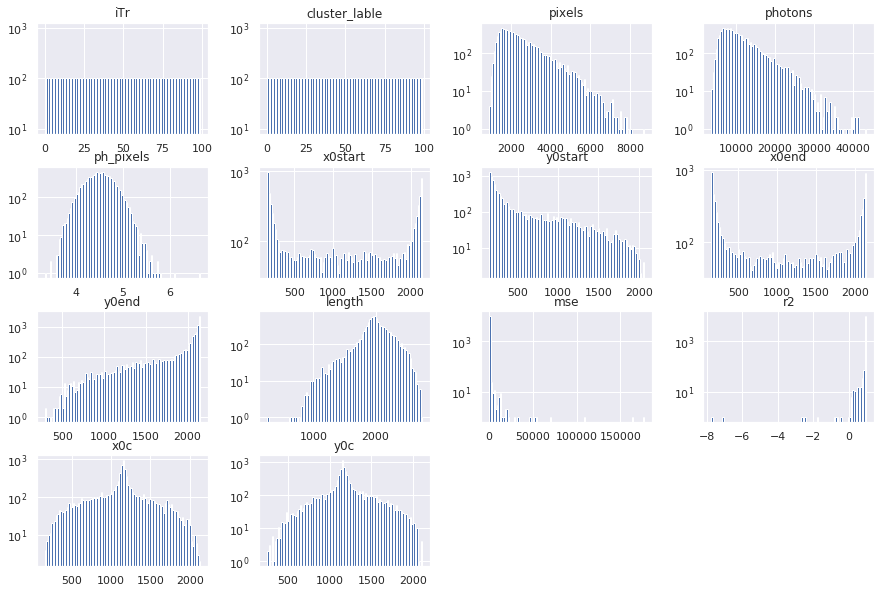

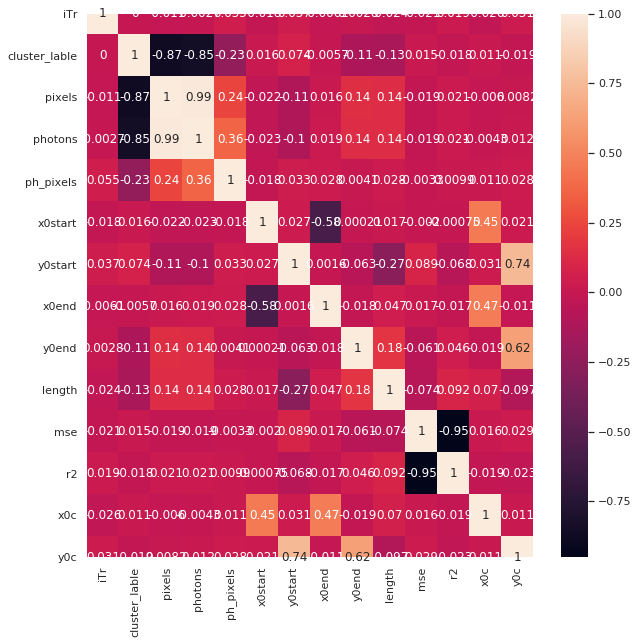

In [5]:
import seaborn as sns
sns.set()
#
# Visulizza tutte le Varibili
#
df.hist(bins=100, figsize=(15,10), log=True)
plt.show()

plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

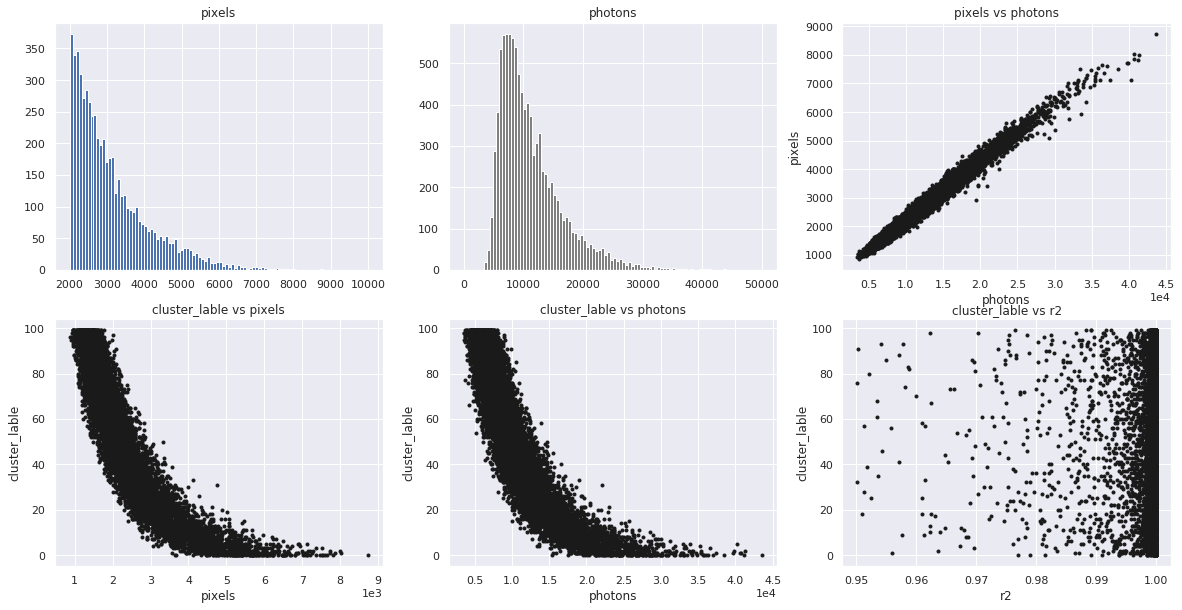

In [160]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
ax[0, 0].set_title('pixels')
ax[0, 0].hist(df.pixels, 100, range=(2000,10000))
ax[0, 1].set_title('photons')
phmax=50000
ax[0, 1].hist(df.photons, 100, range=(0,phmax), color="gray")
ax[0, 2].set_title('pixels vs photons')
ax[0, 2].plot(df.photons[df.photons<phmax].values, df.pixels[df.photons<phmax].values, 'k.')
ax[0, 2].set_xlabel('photons')
ax[0, 2].set_ylabel('pixels')
ax[0, 2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax[1, 0].set_title('cluster_lable vs pixels')
ax[1, 0].plot(df.pixels[df.photons<phmax].values, df.cluster_lable[df.photons<phmax].values, 'k.')
ax[1, 0].set_xlabel('pixels')
ax[1, 0].set_ylabel('cluster_lable')
ax[1, 0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax[1, 1].set_title('cluster_lable vs photons')
ax[1, 1].plot(df.photons[df.photons<phmax].values, df.cluster_lable[df.photons<phmax].values, 'k.')
ax[1, 1].set_xlabel('photons')
ax[1, 1].set_ylabel('cluster_lable')
ax[1, 1].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax[1, 2].set_title('cluster_lable vs r2')
ax[1, 2].plot(df.r2[df.r2>0.95].values, df.cluster_lable[df.r2>0.95].values, 'k.')
ax[1, 2].set_xlabel('r2')
ax[1, 2].set_ylabel('cluster_lable')
ax[1, 2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))

#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
plt.show()

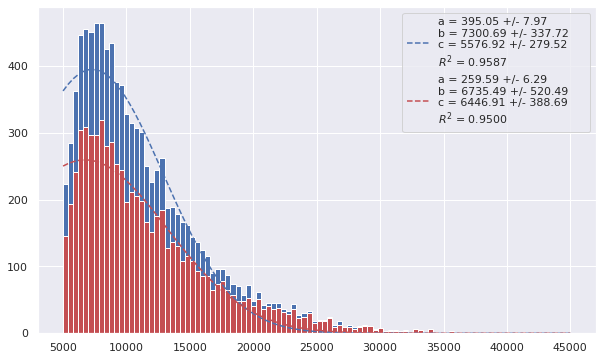

In [157]:
fig, ax = plt.subplots(figsize=(10,6))
histGaus(df.photons, 100, ax, color='b', xrange=(5000,45000), alpha=1, label='')

histGaus(df.photons[df.mse<1], 100, ax, color='r', xrange=(5000,45000), alpha=1, label='')
plt.legend()
plt.show()

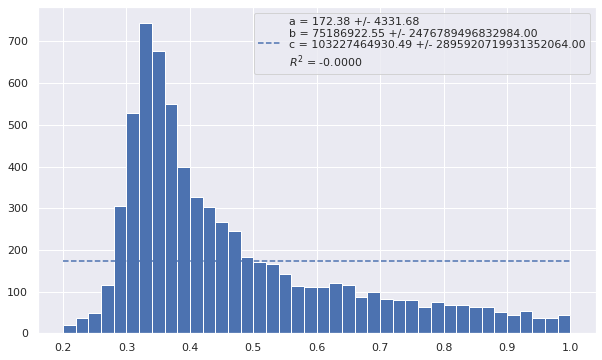

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
histGaus(df.mse, 40, ax, color='b', xrange=(0.2,1), alpha=1, label='')
plt.legend()
plt.show()

In [9]:
len(df.mse[df.mse<1])

6932

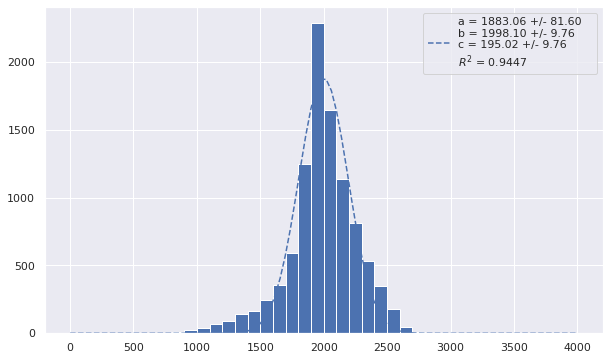

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
histGaus(df.length, 40, ax, color='b', xrange=(0,4000), alpha=1, label='')
plt.legend()
plt.show()

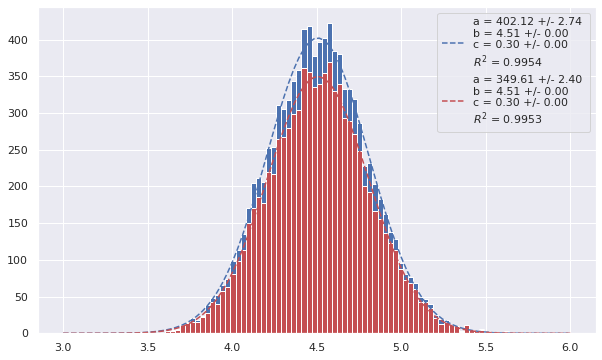

In [152]:
fig, ax = plt.subplots(figsize=(10,6))
histGaus(df.ph_pixels, 100, ax, color='b', xrange=(3,6), alpha=1, label='')
histGaus(df.ph_pixels[df.r2>0.998], 100, ax, color='r', xrange=(3,6), alpha=1, label='')

plt.legend()
plt.show()

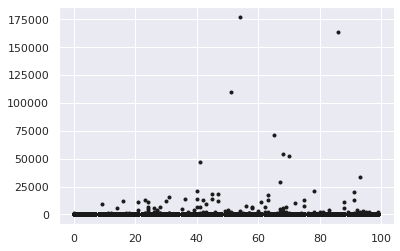

In [11]:
plt.plot(df.cluster_lable.values, df.mse.values, 'k.')
plt.show()

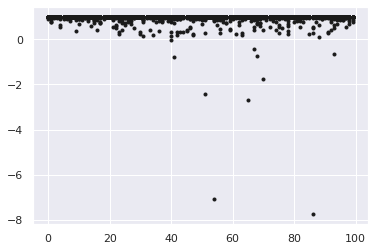

In [12]:
plt.plot(df.cluster_lable.values, df.r2.values, 'k.')
plt.show()

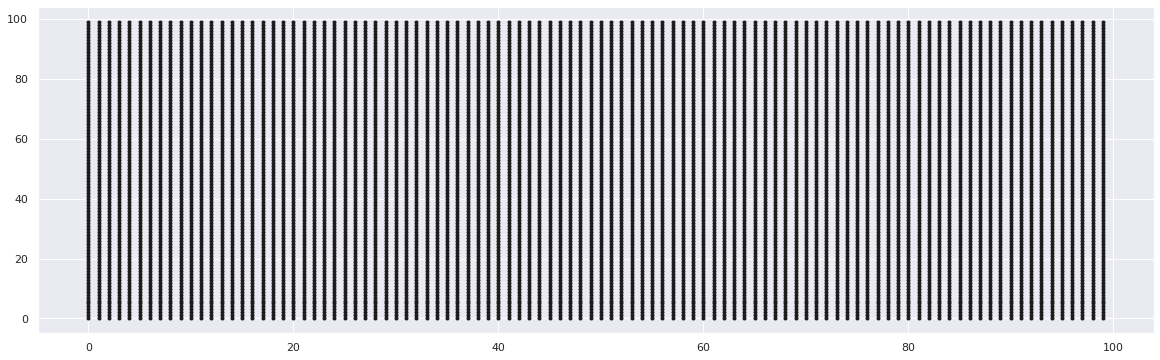

In [13]:
fig, ax = plt.subplots(figsize=(20,6))
plt.plot(df.iTr.values, df.cluster_lable.values, 'k.')
plt.show()

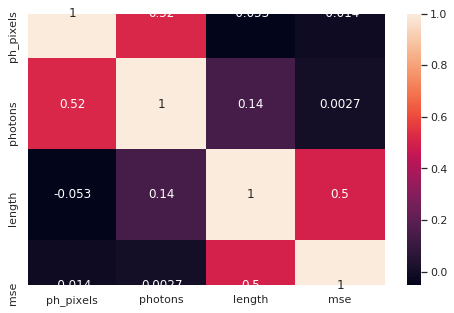

,ph_pixels,photons,length,mse
ph_pixels,1.000000,0.516491,-0.053412,-0.013707
photons,0.516491,1.000000,0.143916,0.002730
length,-0.053412,0.143916,1.000000,0.500219
mse,-0.013707,0.002730,0.500219,1.000000


In [119]:
import seaborn as sns
# pixels	photons	ph_pixels	x0start	y0start	x0end	y0end	length	mse	r2
features = df[['ph_pixels', 'photons', 'length', 'mse']][(df.mse<1) & (df.cluster_lable<10)].copy()
plt.figure(figsize = (8,5))
sns.heatmap(features.corr(), annot=True)
plt.show()

features.corr()

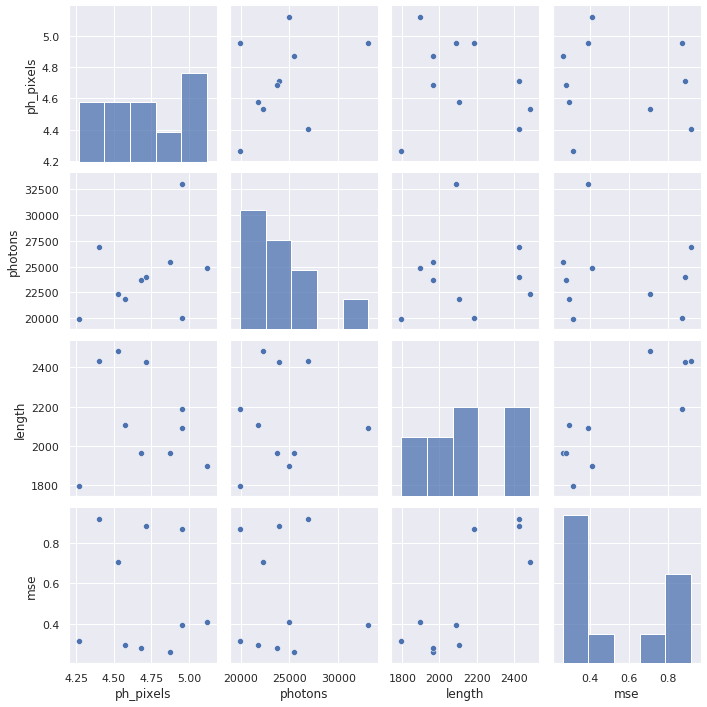

In [120]:
sns.pairplot(features.sample(10))
plt.show()

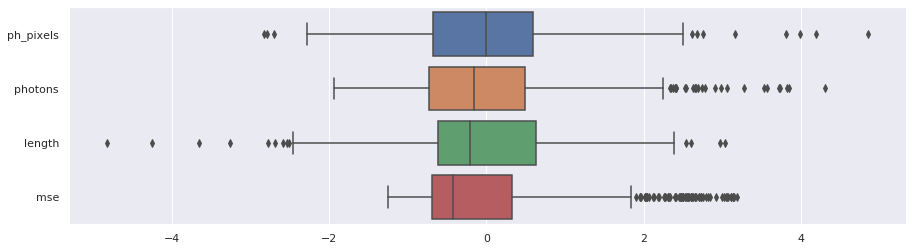

,ph_pixels,photons,length,mse
count,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02
mean,-1.756978e-15,-4.091004e-17,1.087346e-15,8.182007e-17
std,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00
min,-2.824769e+00,-1.933431e+00,-4.830861e+00,-1.250261e+00
25%,-6.803134e-01,-7.293188e-01,-6.191357e-01,-6.874589e-01
50%,-7.096353e-03,-1.592767e-01,-2.062524e-01,-4.229340e-01
75%,5.946351e-01,4.958305e-01,6.306061e-01,3.304624e-01
max,4.846871e+00,4.307335e+00,3.030184e+00,3.183165e+00


In [121]:
# normalizzazione delle variabili

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
# pixels	photons	ph_pixels	x0start	y0start	x0end	y0end	length	mse	r2
scaled_dataframe = pd.DataFrame( scaled_array, columns = features.columns ) # df.colums per tutte e colonne
plt.figure(figsize = (15,4))
sns.boxplot(data = scaled_dataframe, orient = "h")
plt.show()
scaled_dataframe.describe()

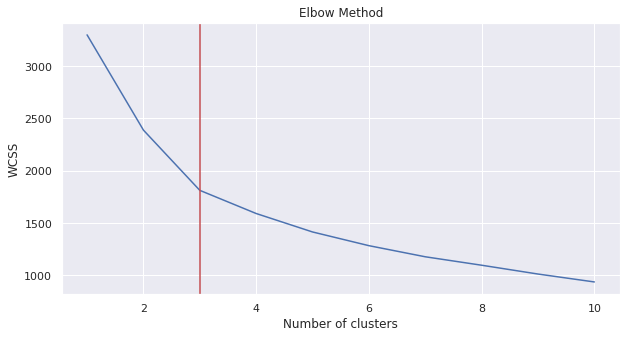

In [122]:
from sklearn.cluster import KMeans
plt.figure(figsize = (10,5))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_dataframe)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.axvline(3, color = "r")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [123]:
from sklearn import metrics
k_to_test = range(2,25,1) # [2,3,4, ..., 24]
silhouette_scores = []

for k in k_to_test:
    model_kmeans_k = KMeans( n_clusters = k )
    model_kmeans_k.fit(scaled_dataframe)
    labels_k = model_kmeans_k.labels_
    score_k = metrics.silhouette_score(scaled_dataframe, labels_k)
    silhouette_scores.append(score_k)
    print("Tested kMeans with k = %d\tSS: %5.4f" % (k, score_k))
    
print("Done!")

Tested kMeans with k = 2	SS: 0.3278
Tested kMeans with k = 3	SS: 0.2751
Tested kMeans with k = 4	SS: 0.2492
Tested kMeans with k = 5	SS: 0.2386
Tested kMeans with k = 6	SS: 0.2235
Tested kMeans with k = 7	SS: 0.2217
Tested kMeans with k = 8	SS: 0.2349
Tested kMeans with k = 9	SS: 0.2261
Tested kMeans with k = 10	SS: 0.2262
Tested kMeans with k = 11	SS: 0.2311
Tested kMeans with k = 12	SS: 0.2275
Tested kMeans with k = 13	SS: 0.2226
Tested kMeans with k = 14	SS: 0.2214
Tested kMeans with k = 15	SS: 0.2118
Tested kMeans with k = 16	SS: 0.2211
Tested kMeans with k = 17	SS: 0.2171
Tested kMeans with k = 18	SS: 0.2161
Tested kMeans with k = 19	SS: 0.2115
Tested kMeans with k = 20	SS: 0.2062
Tested kMeans with k = 21	SS: 0.2080
Tested kMeans with k = 22	SS: 0.2146
Tested kMeans with k = 23	SS: 0.2117
Tested kMeans with k = 24	SS: 0.2028
Done!


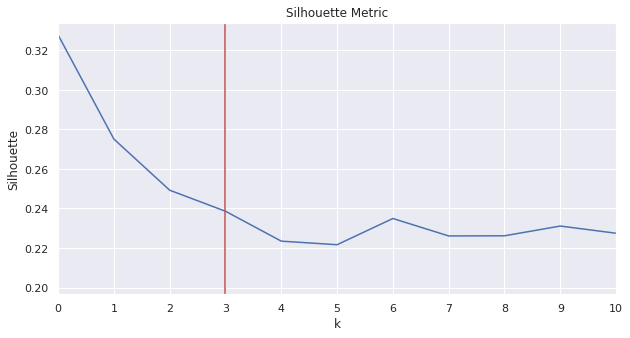

In [124]:
plt.figure(figsize = (10,5))
plt.plot(np.array(silhouette_scores))
plt.xticks(range(0,23,1))
plt.title("Silhouette Metric")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.axvline(3, color = "r")
plt.xlim(0,10)
plt.show()

In [125]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(scaled_dataframe)
features['cluster'] = kmeans.labels_

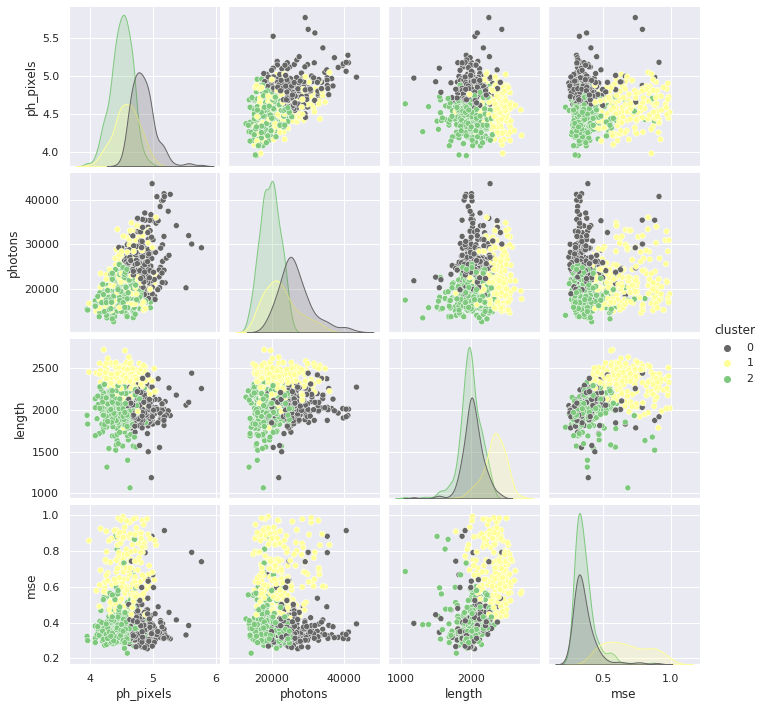

In [126]:
sns.pairplot(data = features, hue = "cluster", palette = "Accent_r")
plt.show()

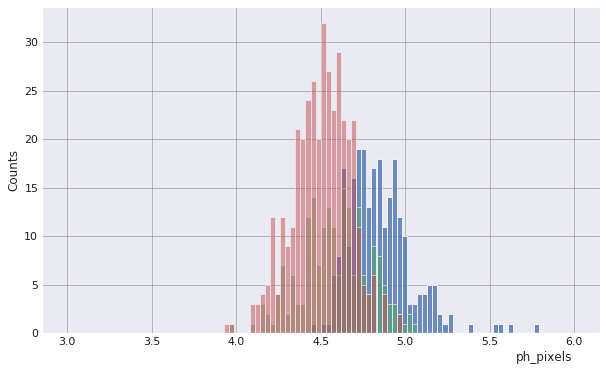

In [127]:
fig, ax = plt.subplots(figsize=(10,6))
from mpl_toolkits.mplot3d import Axes3D

plt.hist(features.ph_pixels[features.cluster==0], bins=100, color='b', alpha=0.8, range=(3, 6))
plt.hist(features.ph_pixels[features.cluster==1], bins=100, color='g', alpha=0.5, range=(3, 6))
plt.hist(features.ph_pixels[features.cluster==2], bins=100, color='r', alpha=0.5, range=(3, 6))
#plt.yscale('Log')
plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
plt.xlabel('ph_pixels', x=0.9)
plt.ylabel('Counts')
plt.show()

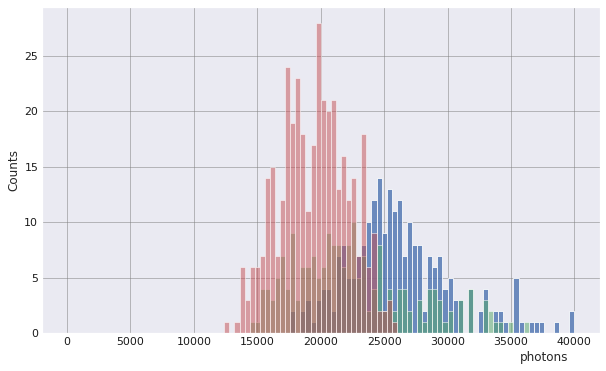

In [128]:
fig, ax = plt.subplots(figsize=(10,6))
from mpl_toolkits.mplot3d import Axes3D

plt.hist(features.photons[features.cluster==0], bins=100, color='b', alpha=0.8, range=(0, 40000))
plt.hist(features.photons[features.cluster==1], bins=100, color='g', alpha=0.5, range=(0, 40000))
plt.hist(features.photons[features.cluster==2], bins=100, color='r', alpha=0.5, range=(0, 40000))
#plt.yscale('Log')
plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
plt.xlabel('photons', x=0.9)
plt.ylabel('Counts')
plt.show()

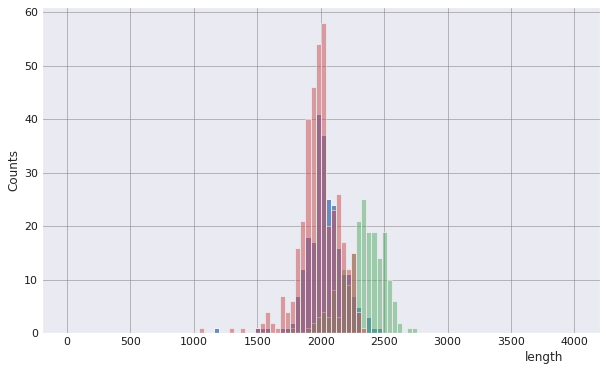

In [129]:
fig, ax = plt.subplots(figsize=(10,6))
from mpl_toolkits.mplot3d import Axes3D

plt.hist(features.length[features.cluster==0], bins=100, color='b', alpha=0.8, range=(0, 4000))
plt.hist(features.length[features.cluster==1], bins=100, color='g', alpha=0.5, range=(0, 4000))
plt.hist(features.length[features.cluster==2], bins=100, color='r', alpha=0.5, range=(0, 4000))
#plt.yscale('Log')
plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
plt.xlabel('length', x=0.9)
plt.ylabel('Counts')
plt.show()

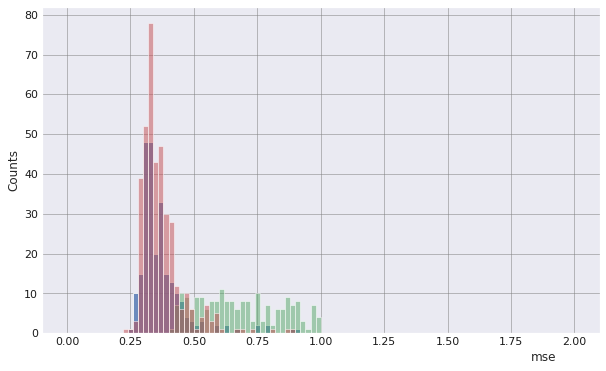

In [130]:
fig, ax = plt.subplots(figsize=(10,6))
from mpl_toolkits.mplot3d import Axes3D

plt.hist(features.mse[features.cluster==0], bins=100, color='b', alpha=0.8, range=(0, 2))
plt.hist(features.mse[features.cluster==1], bins=100, color='g', alpha=0.5, range=(0, 2))
plt.hist(features.mse[features.cluster==2], bins=100, color='r', alpha=0.5, range=(0, 2))
#plt.yscale('Log')00
plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
plt.xlabel('mse', x=0.9)
plt.ylabel('Counts')
plt.show()